In [1]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import os

import h5py
import corner

%load_ext autoreload
%autoreload 2
import plotter
import emulator

In [2]:
param_labels = {'Omega_m': '$\Omega_m$', 
                'Omega_b': '$\Omega_b$', 
                'sigma_8': '$\sigma_8$', 
                'h': '$h$', 
                'n_s': '$n_s$',
                'N_eff': '$N_{eff}$', 
                'w': '$w$', 
                'M_sat': '$M_{sat}$', 
                'alpha': '$\alpha$', 
                'M_cut': '$M_{cut}$', 
                'sigma_logM': '$\sigma_{logM}$', 
                'v_bc': '$v_{bc}$', 
                'v_bs': '$v_{bs}$', 
                'c_vir': '$c_{vir}$', 
                'f': '$f$', 
                'f_env': '$f_{env}$', 
                'delta_env': '$\delta_{env}$', 
                'sigma_env': '$\sigma_{env}$'}

In [3]:
cosmo, hod = 3, 3
statistic = 'wp'
traintag = '_nonolap'
testtag = '_mean_test0'
errtag = '_100hod_test0'
kernel_name = 'M32ExpConst2'
nhod = 100
tag = '_log_kM32ExpConst2_{}hod'.format(nhod)

gptag = traintag + errtag + tag
res_dir = '../../clust/results_{}/'.format(statistic)
gperr = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))
training_dir = '{}training_{}{}/'.format(res_dir, statistic, traintag)
testing_dir = '{}testing_{}{}/'.format(res_dir, statistic, testtag)
hyperparams = "../training_results/{}_training_results{}.dat".format(statistic, gptag)

emu = emulator.Emulator(statistic, training_dir, gperr=gperr, hyperparams=hyperparams, nhod=nhod, kernel_name=kernel_name)
emu.build()

george version: 0.3.1
Loading training data
Nparams: 18
Rebuilding emulators


In [4]:
def load_chains(chaintag, show_walkers=False, show_corner=True, show_params=None, figure=None, nsteps=None, color='blue'): 
    #chaintag = 'wp_c3h3_Msat_fenv_xlong_diag'
    chain_fn = f'../chains/chains_{chaintag}.h5'
    fw = h5py.File(chain_fn, 'r')

    chain_dset = fw['chain']
    print(chain_dset)
    chain = np.array(chain_dset)
    lnprob_dset = fw['lnprob']
    param_names = fw.attrs['param_names']
    true_values = fw.attrs['true_values']
    if nsteps:
        chain = chain[:,:nsteps,:]
    nwalkers, nchain, ndim = chain.shape
    fw.close()
    
    if show_params:    
        idxs = []
        for sp in show_params:
            idxs.append(np.where(param_names == sp))
        idxs = np.array(idxs).flatten()
        chain = chain[:,:,idxs]
        param_names = show_params
        true_values = true_values[idxs]

    return chain

In [5]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

In [6]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [7]:
def plot_autocorr(chain):
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    ndim = chain.shape[2]
    auto = np.empty((len(N), ndim))
    for i, n in enumerate(N):
        for d in range(ndim):
            auto[i][d] = autocorr_new(chain[:, :n, d])
    
    # Plot the comparisons
    for d in range(ndim):
        plt.loglog(N, auto, "o-",)
    ylim = plt.gca().get_ylim()
    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    #plt.ylim(ylim)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14)

### All cosmo

<HDF5 dataset "chain": shape (96, 20000, 7), type "<f4">


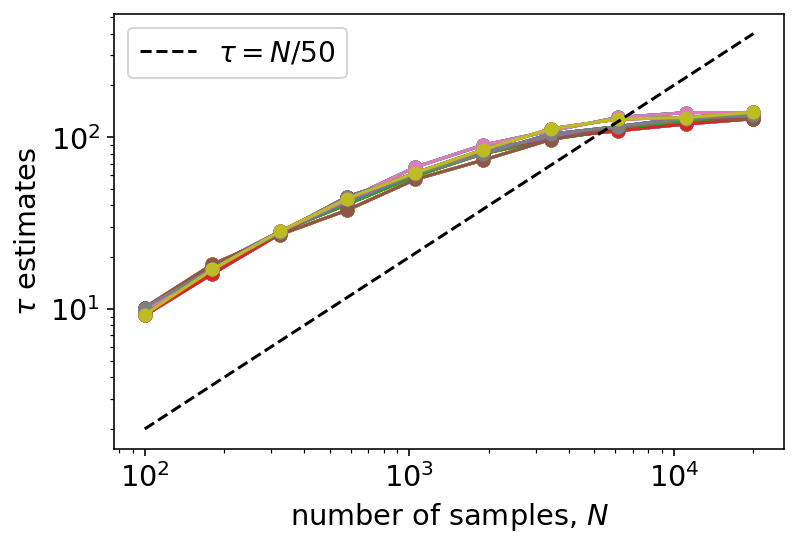

In [33]:
chain = load_chains('upf_c3h3_allcosmo2_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 20000, 7), type "<f4">


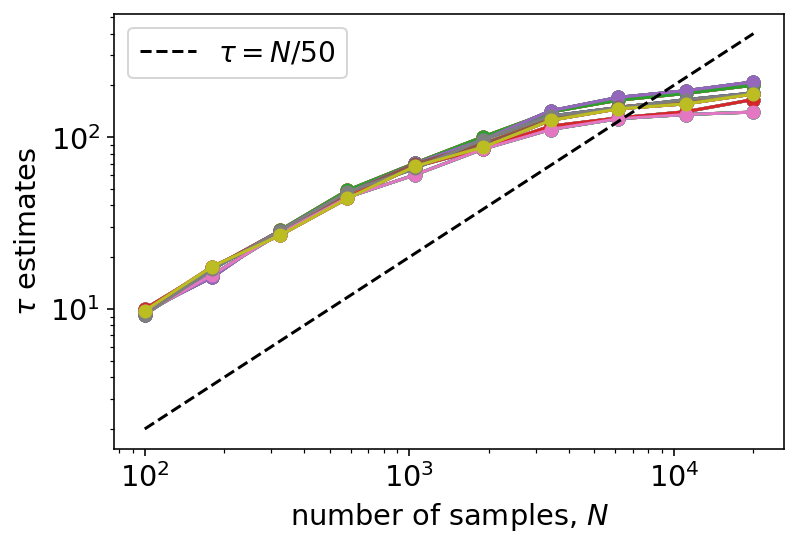

In [40]:
chain = load_chains('wp_c3h3_allcosmo_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 14800, 7), type "<f4">


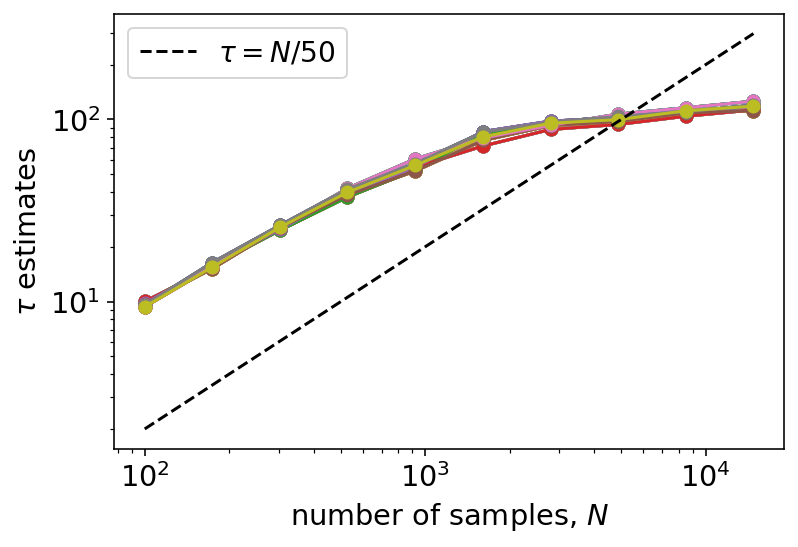

In [34]:
chain = load_chains('wp_upf_c3h3_allcosmo_covperf')
plot_autocorr(chain)

### All HOD

<HDF5 dataset "chain": shape (96, 15500, 11), type "<f4">


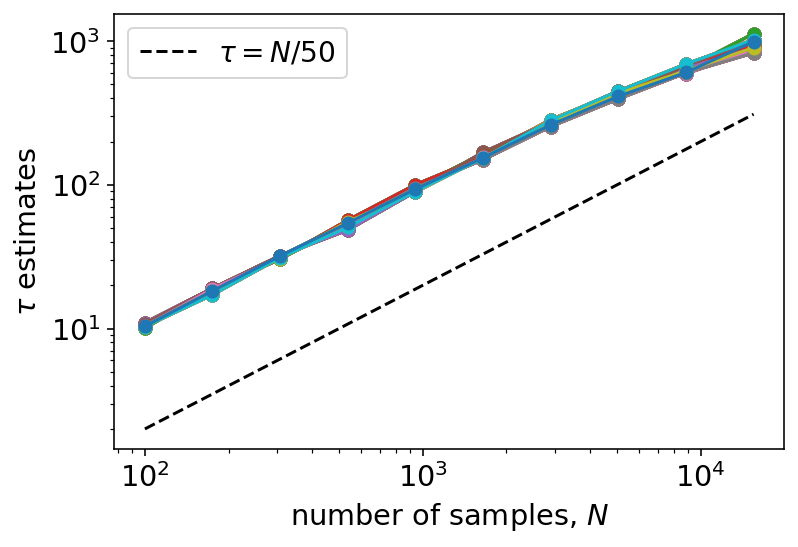

In [8]:
chain = load_chains('upf_c3h3_allhod_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 20000, 11), type "<f4">


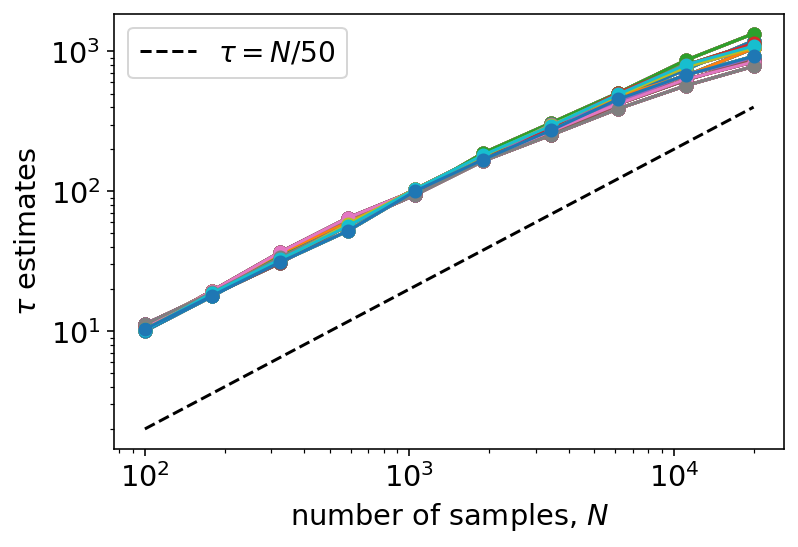

In [43]:
chain = load_chains('wp_c3h3_allhod_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 19100, 11), type "<f4">


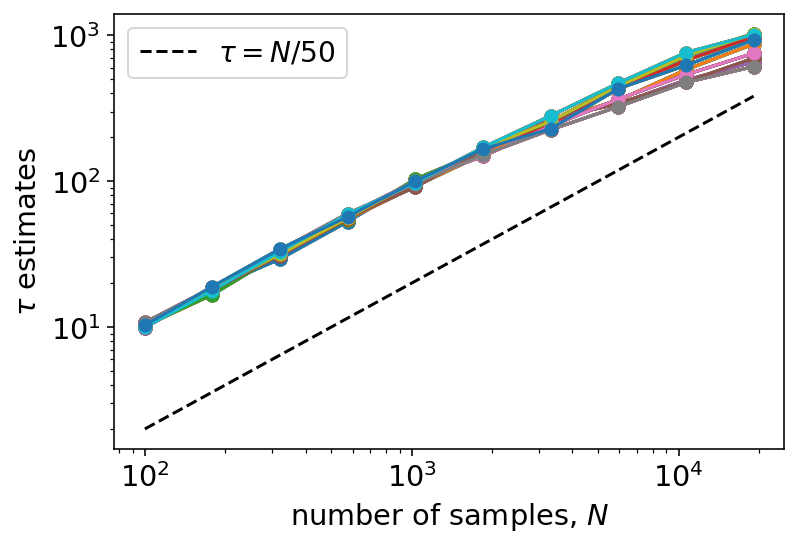

In [44]:
chain = load_chains('wp_upf_c3h3_allhod_covperf')
plot_autocorr(chain)

### All (cosmo & HOD)

<HDF5 dataset "chain": shape (96, 30000, 18), type "<f4">


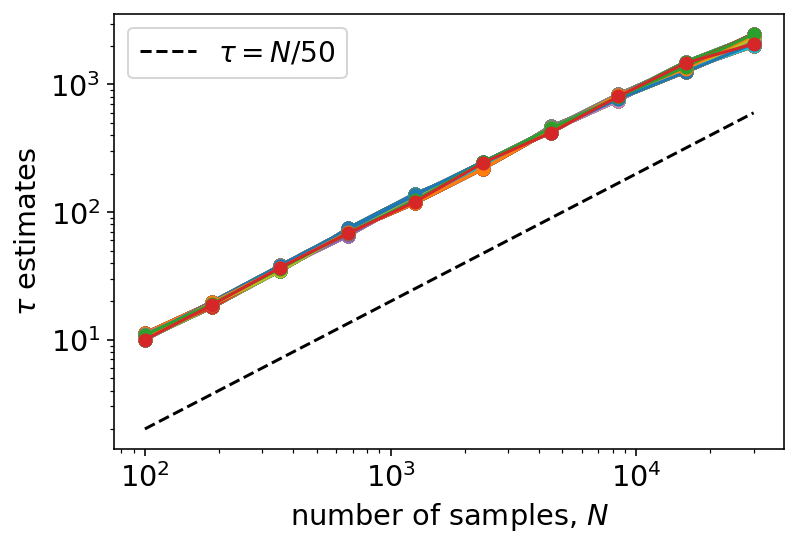

In [10]:
chain = load_chains('upf_c3h3_all_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 30000, 18), type "<f4">


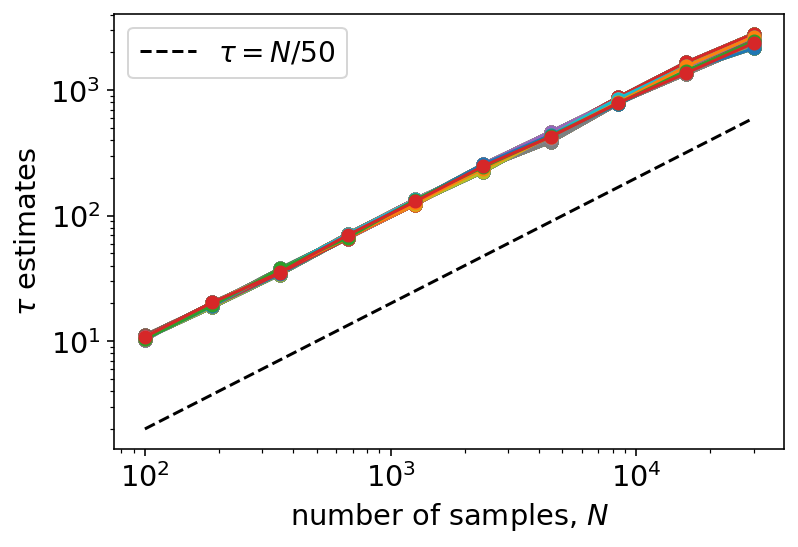

In [9]:
chain = load_chains('wp_c3h3_all_covperf')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (96, 22000, 18), type "<f4">


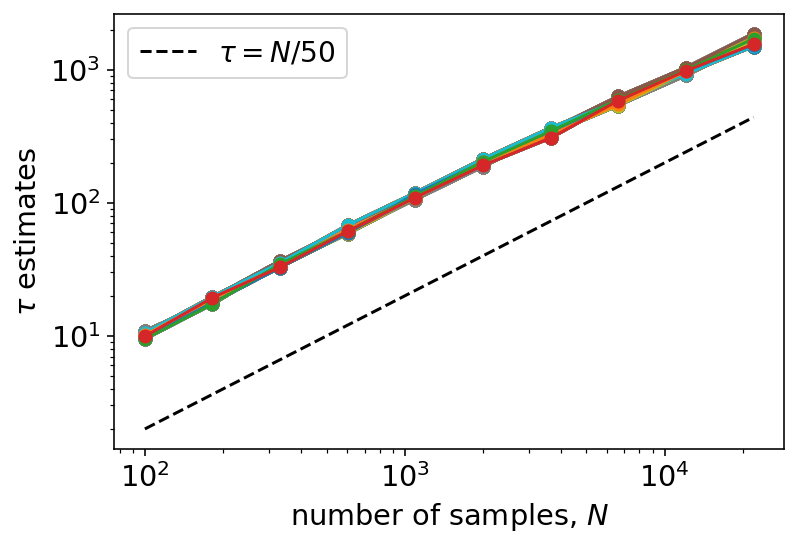

In [35]:
chain = load_chains('wp_upf_c3h3_all_covperf')
plot_autocorr(chain)

## nw250

<HDF5 dataset "chain": shape (250, 7100, 11), type "<f4">


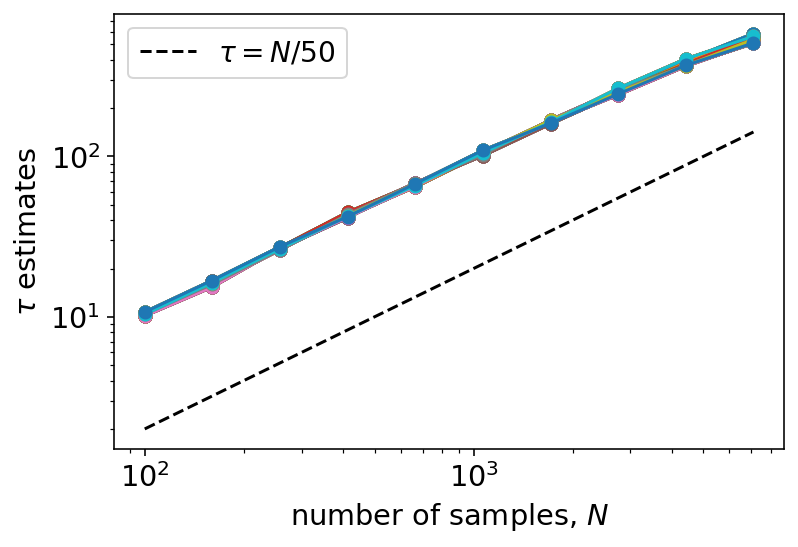

In [8]:
chain = load_chains('upf_c3h3_allhod_covperf_nw250')
plot_autocorr(chain)

In [9]:
chain = load_chains('upf_c3h3_allcosmo_covperf_nw250')
plot_autocorr(chain)

OSError: Unable to open file (unable to open file: name = '../chains/chains_upf_c3h3_allcosmo_covperf_nw250.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<HDF5 dataset "chain": shape (250, 24700, 18), type "<f4">


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


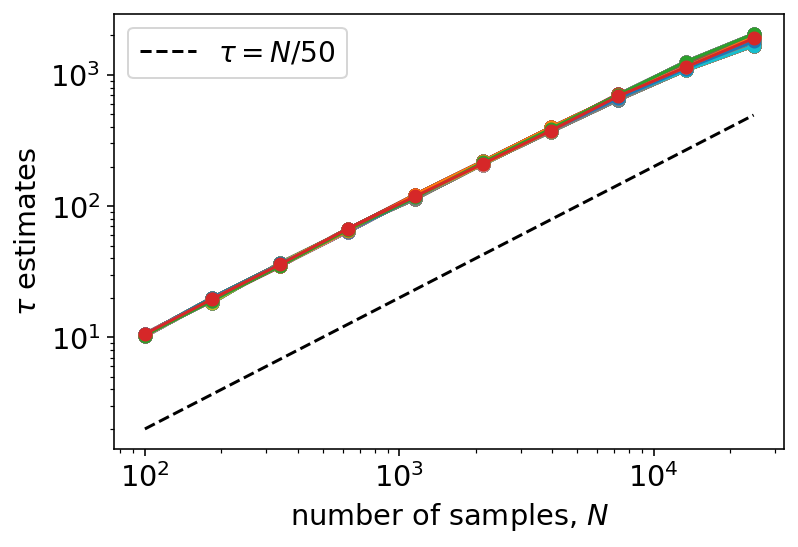

In [12]:
chain = load_chains('upf_c3h3_all_covperf_nw250')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (250, 19200, 7), type "<f4">


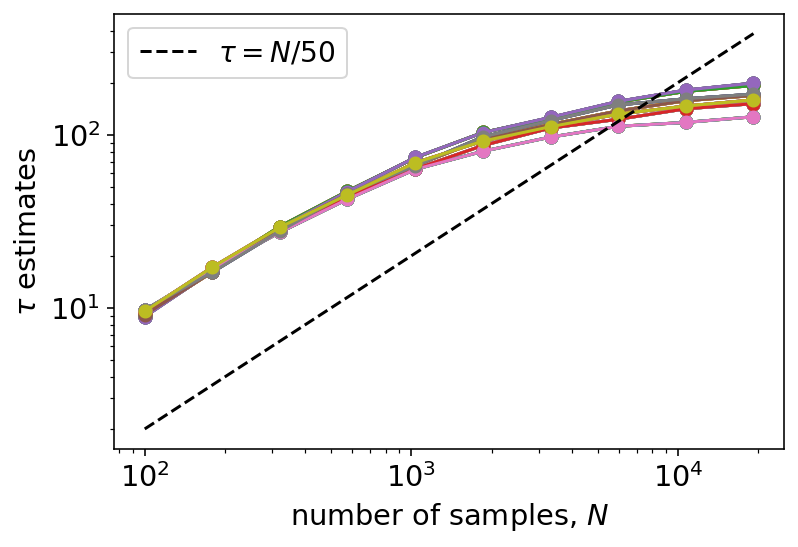

In [10]:
chain = load_chains('wp_c3h3_allcosmo_covperf_nw250')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (250, 27300, 18), type "<f4">


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


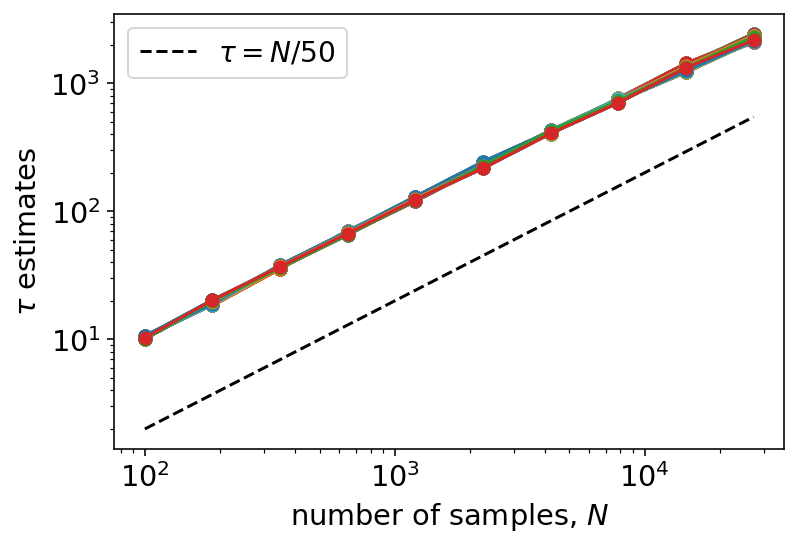

In [11]:
chain = load_chains('wp_c3h3_all_covperf_nw250')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (250, 7300, 7), type "<f4">


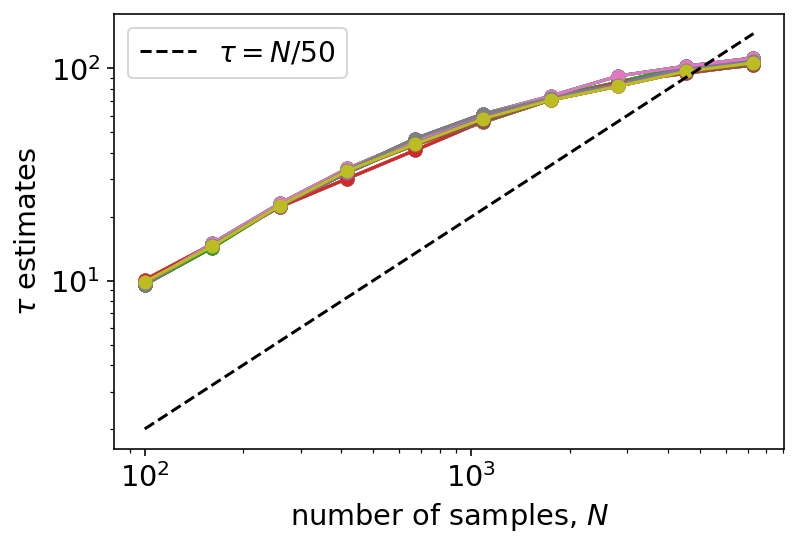

In [12]:
chain = load_chains('wp_upf_c3h3_allcosmo_covperf_nw250')
plot_autocorr(chain)

<HDF5 dataset "chain": shape (250, 10500, 18), type "<f4">


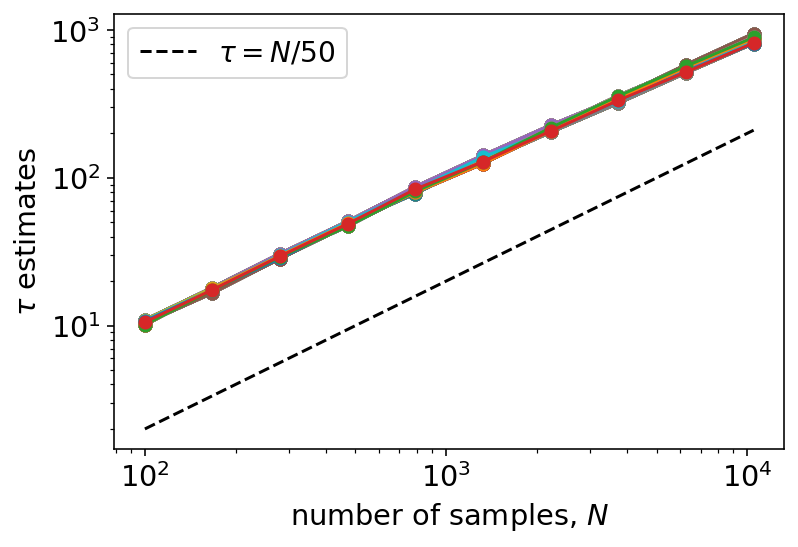

In [13]:
chain = load_chains('wp_upf_c3h3_all_covperf_nw250')
plot_autocorr(chain)